IMPORT LIBRARIES

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version 2.3.0


LOAD AND INSPECT THE S&P 500 DATA: 1986-2018

In [2]:
from google.colab import files
uploaded = files.upload()

Saving S&P_500_Index_Data.csv to S&P_500_Index_Data.csv


In [3]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [4]:
df.shape

(8192, 2)

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close, mode='lines', name='close'))
fig.update_layout(showlegend=True)
fig.show()

DATA PREPROCESSING

In [6]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

CREATE TRAINING AND TEST SPLITS

In [13]:
def create_sequences(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    Xs.append(X.iloc[i: (i+time_steps)].values)
    ys.append(y.iloc[i+ time_steps])
  return np.array(Xs), np.array(ys) 

In [14]:
time_steps = 30
X_train, y_train = create_sequences(train[['close']], train.close, time_steps)
X_test, y_test = create_sequences(test[['close']], test.close, time_steps)


In [15]:
print(X_train.shape)

(6523, 30, 1)


BUILD AN LSTM AUTOENCODER

In [16]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
                    LSTM(128, input_shape=(timesteps, num_features)),
                    Dropout(0.2),
                    RepeatVector(timesteps),
                    LSTM(128, return_sequences=True),
                    Dropout(0.2),
                    TimeDistributed(Dense(num_features))

])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

TRAIN THE AUTOENCODER

In [18]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
184/184 [==============================] - 14s 74ms/step - loss: 0.1652 - val_loss: 0.1742
Epoch 2/100
184/184 [==============================] - 13s 69ms/step - loss: 0.1136 - val_loss: 0.0572
Epoch 3/100
184/184 [==============================] - 13s 69ms/step - loss: 0.0901 - val_loss: 0.0524
Epoch 4/100
184/184 [==============================] - 13s 69ms/step - loss: 0.0808 - val_loss: 0.0530
Epoch 5/100
184/184 [==============================] - 13s 69ms/step - loss: 0.0762 - val_loss: 0.0427
Epoch 6/100
184/184 [==============================] - 13s 69ms/step - loss: 0.0773 - val_loss: 0.0486
Epoch 7/100
184/184 [==============================] - 13s 70ms/step - loss: 0.0754 - val_loss: 0.0768
Epoch 8/100
184/184 [==============================] - 13s 71ms/step - loss: 0.0765 - val_loss: 0.0380
Epoch 9/100
184/184 [==============================] - 13s 71ms/step - loss: 0.0715 - val_loss: 0.0283
Epoch 10/100
184/184 [==============================] - 13s 69ms/step - l

PLOT METRICS AND EVALUATE THE MODEL

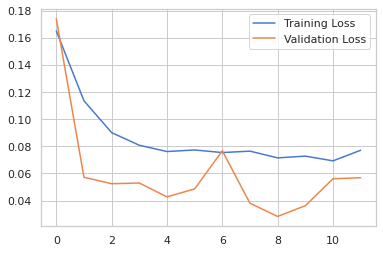

In [20]:
plt.plot(history.history['loss'], label='Training Loss' )
plt.plot(history.history['val_loss'], label='Validation Loss' )
plt.legend();

In [21]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error']);

In [22]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 19ms/step - loss: 0.3637


0.3636506497859955

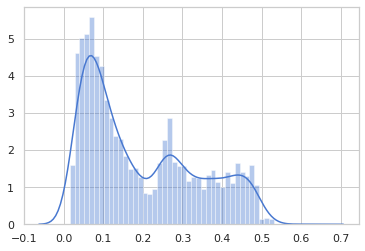

In [24]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [33]:
threshold = 0.65

In [34]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:
DETECT ANOMALIES IN S&P 500

In [35]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [36]:
test_score_df.head()

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.056087,0.65,False
6584,2012-02-09,1.221625,0.056091,0.65,False
6585,2012-02-10,1.199313,0.055967,0.65,False
6586,2012-02-13,1.221194,0.055956,0.65,False
6587,2012-02-14,1.218150,0.054454,0.65,False


In [37]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
8187,2018-06-25,4.493228,0.728039,0.65,True
8188,2018-06-26,4.507583,0.773667,0.65,True
8189,2018-06-27,4.451431,0.783855,0.65,True
8190,2018-06-28,4.491406,0.813501,0.65,True
8191,2018-06-29,4.496343,0.802877,0.65,True


In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                         mode='lines',name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                         mode='lines',name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [41]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.721399,0.65,True
7475,2015-08-26,2.632149,0.789023,0.65,True
7476,2015-08-27,2.745147,0.697441,0.65,True
8090,2018-02-05,4.329949,0.729003,0.65,True
8091,2018-02-06,4.440671,0.899477,0.65,True


In [44]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                         mode='lines',name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                         mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()